# make figure summarizing phytoplankton changes

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint100m','spC_zint100m','zooC_zint100m',
             'spNPP_zint100m','diatNPP_zint100m','NPP_zint100m','zoo_prod_zint100m',
             'TEMP_100m_mean','SHF_QSW','Fe_avg_100m','phys_med_Fe','NO3_100m_mean',
             'PAR_avg_100m']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
NO3_100m_mean
PAR_avg_100m
CPU times: user 881 ms, sys: 56.1 ms, total: 937 ms
Wall time: 1.78 s


In [3]:
ds['mesozooC'] = ds.zooC_zint100m * (ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m))
ds['diat_frac'] = ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m)
ds['sp_frac'] = ds.spC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m)
ds['microzooC'] = ds.zooC_zint100m * ds['sp_frac']

ds['mesozooC_prod'] = ds.zoo_prod_zint100m * ds.diat_frac
ds['microzooC_prod'] = ds.zoo_prod_zint100m * ds.sp_frac
ds['diat_frac_NPP'] = ds.diatNPP_zint100m/(ds.diatNPP_zint100m + ds.spNPP_zint100m)

ds['phytoC_zint'] = ds.spC_zint100m + ds.diatC_zint100m

ds['PAR_surf'] = ds.SHF_QSW * 0.45

In [4]:
variables = variables + ['mesozooC','diat_frac','mesozooC_prod','diat_frac_NPP',
             'phytoC_zint','PAR_surf','microzooC','microzooC_prod']

### get pop grid

In [5]:
grid = pop_tools.get_grid('POP_gx1v6')

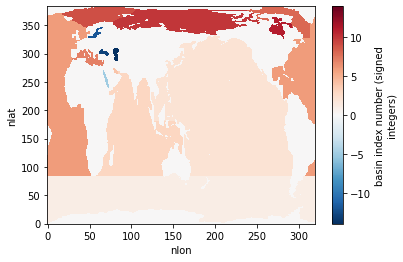

In [6]:
grid.REGION_MASK.plot()

In [7]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [8]:
ds = ds.where(grid.REGION_MASK>0)

### convert rate vars

In [9]:
### convert production from mmol/m3 cm/sec to gC/m2/y
ds['zoo_prod_zint100m'] = ds.zoo_prod_zint100m * 365. * 0.001 * 12.
ds.zoo_prod_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['mesozooC_prod'] = ds.mesozooC_prod * 0.01 * 86400. * 365. * 0.001 * 12.
ds.mesozooC_prod.attrs['units'] = 'gC m-2 y-1'

ds['microzooC_prod'] = ds.microzooC_prod * 0.01 * 86400. * 365. * 0.001 * 12.
ds.mesozooC_prod.attrs['units'] = 'gC m-2 y-1'

ds['NPP_zint100m'] = ds.NPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.NPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['diatNPP_zint100m'] = ds.diatNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.diatNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['spNPP_zint100m'] = ds.spNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.spNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

convert = 0.01 * 86400. * 1000. *1000. #converting from mmol/m3 cm/s to nmol/m2/d
ds['phys_med_Fe'] = ds.phys_med_Fe * convert
ds.phys_med_Fe.attrs['units'] = 'nmol/m^2/d'

### Calculate temperature scaling for TL3 productivity

In [10]:
## create Ft grid
Ft = np.full((34, 181, 384, 320), 1, dtype=float)
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id',
              'dim_1':'time',
              'dim_2':'nlat',
              'dim_3':'nlon'})

Ft_cold = Ft.where(ds.TEMP_100m_mean < 20.)
Ft_warm =  Ft.where(ds.TEMP_100m_mean >= 20.) * 0.74

#now convert everything to numpy arrays so we can merge the two grids
Ft = np.asarray(Ft)
Ft_cold = np.asarray(Ft_cold)
Ft_warm = np.asarray(Ft_warm)

Ft[~np.isnan(Ft_cold)] = Ft_cold[~np.isnan(Ft_cold)]
Ft[~np.isnan(Ft_warm)] = Ft_warm[~np.isnan(Ft_warm)]

#now put it back to an xarray
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id',
              'dim_1':'time',
              'dim_2':'nlat',
              'dim_3':'nlon'})

### mask out land
Ft = Ft.where(grid.REGION_MASK>0)

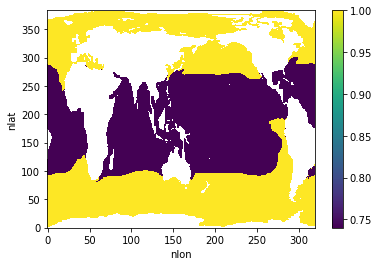

In [11]:
Ft.isel(time=8,member_id=3).plot()

In [12]:
Ft['time'] = ds.time
Ft['member_id'] = ds.member_id

In [13]:
ds.zoo_prod_zint100m

<xarray.DataArray 'zoo_prod_zint100m' (time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<mul, shape=(181, 34, 384, 320), dtype=float64, chunksize=(181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Zooplankton production depth integrated to 100m
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [14]:
#trophic level 3
L = 3
alpha = 1 #0.14 changed this to one since we're not "harvesting" TL3
E = 0.14

ds['TL3_prod'] = alpha * ds['mesozooC_prod'] * (Ft * E)**(L-2.1) #answer will be in gC/m2/y
ds.TL3_prod.attrs = ds.zoo_prod_zint100m.attrs
ds.TL3_prod.attrs['long_name'] = 'trophic level 3 production'

### Calculate ETE to TL3

In [15]:
ds['ETE_to_TL3'] = ds.TL3_prod/ds.NPP_zint100m

In [16]:
variables = variables + ['TL3_prod','ETE_to_TL3']

### extract 1920s

In [17]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [18]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 2090s

In [19]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [20]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

In [21]:
# ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
# ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
# ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

### Read in masks

In [22]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1920s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

In [23]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC = ACC.where(grid.REGION_MASK>0)
#ACC.plot()

In [24]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ = SIZ.where(grid.REGION_MASK>0)
#SIZ.plot()

### spin up dask

In [25]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='256 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(8)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [26]:
client

Client Scheduler: tcp://10.12.206.42:46675 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [27]:
%%time
ACC_1920s_ds = xr.Dataset()
ACC_2090s_ds = xr.Dataset()
SIZ_1920s_ds = xr.Dataset()
SIZ_2090s_ds = xr.Dataset()

for v in variables:
    print(v)

    masked = ds_1920s[v].where(ACC==1)
    ACC_1920s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ds_2090s[v].where(ACC==1)
    ACC_2090s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
    
    masked = ds_1920s[v].where(SIZ==1)
    SIZ_1920s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ds_2090s[v].where(SIZ==1)
    SIZ_2090s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
    

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
NO3_100m_mean
PAR_avg_100m
mesozooC
diat_frac
mesozooC_prod
diat_frac_NPP
phytoC_zint
PAR_surf
microzooC
microzooC_prod
TL3_prod
ETE_to_TL3
CPU times: user 1min 11s, sys: 46.2 s, total: 1min 57s
Wall time: 22min 20s


### Figures

In [28]:
SIZ_1920s_ds.TEMP_100m_mean

<xarray.DataArray 'TEMP_100m_mean' (member_id: 34)>
array([-1.50742854, -1.50686161, -1.52949074, -1.5176177 , -1.50746556,
       -1.49116683, -1.51671124, -1.51314078, -1.51121389, -1.53594237,
       -1.49222237, -1.50100613, -1.51673837, -1.51340964, -1.51266052,
       -1.49382143, -1.52539099, -1.48435241, -1.48556991, -1.50655048,
       -1.50835778, -1.51707513, -1.49879219, -1.48224524, -1.50458162,
       -1.51222668, -1.50603953, -1.51491785, -1.49187439, -1.52762625,
       -1.50939462, -1.50282765, -1.47900008, -1.50522331])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     Mean temperature over top 100m
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [30]:
ACC_1920s_ds

<xarray.Dataset>
Dimensions:            (member_id: 34)
Coordinates:
  * member_id          (member_id) int64 1 2 9 10 11 12 ... 101 102 103 104 105
Data variables: (12/23)
    diatC_zint100m     (member_id) float64 58.52 59.69 60.54 ... 58.78 59.51
    spC_zint100m       (member_id) float64 65.71 64.8 65.53 ... 64.86 64.76
    zooC_zint100m      (member_id) float64 76.99 76.5 77.11 ... 76.27 76.74
    spNPP_zint100m     (member_id) float64 56.83 56.27 56.3 ... 56.57 56.03
    diatNPP_zint100m   (member_id) float64 44.98 45.82 46.17 ... 45.24 45.76
    NPP_zint100m       (member_id) float64 101.8 102.1 102.5 ... 101.8 101.8
    ...                 ...
    phytoC_zint        (member_id) float64 124.2 124.5 126.1 ... 123.6 124.3
    PAR_surf           (member_id) float64 48.71 48.71 48.69 ... 48.65 48.7
    microzooC          (member_id) float64 42.96 42.35 42.79 ... 42.47 42.5
    microzooC_prod     (member_id) float64 11.96 11.81 11.85 ... 11.86 11.78
    TL3_prod           (member_id) float64 1.75 1.765 1.771 ... 1.749 1.766
    ETE_to_TL3         (member_id) float64 0.01618 0.01616 ... 0.0161 0.01619

In [32]:
diff_ACC_ds = ACC_2090s_ds - ACC_1920s_ds

In [33]:
diff_ACC_ds

<xarray.Dataset>
Dimensions:            (member_id: 34)
Coordinates:
  * member_id          (member_id) int64 1 2 9 10 11 12 ... 101 102 103 104 105
Data variables: (12/23)
    diatC_zint100m     (member_id) float64 5.317 5.209 1.397 ... 1.592 4.778
    spC_zint100m       (member_id) float64 -16.33 -15.19 ... -14.31 -15.29
    zooC_zint100m      (member_id) float64 -4.995 -4.007 ... -4.161 -5.021
    spNPP_zint100m     (member_id) float64 -5.755 -4.711 -4.4 ... -3.602 -4.62
    diatNPP_zint100m   (member_id) float64 13.13 13.14 10.71 ... 10.78 13.32
    NPP_zint100m       (member_id) float64 7.374 8.432 6.311 ... 8.749 7.183 8.7
    ...                 ...
    phytoC_zint        (member_id) float64 -11.02 -9.981 ... -12.72 -10.51
    PAR_surf           (member_id) float64 -2.283 -2.138 ... -2.306 -2.327
    microzooC          (member_id) float64 -8.684 -7.949 ... -7.255 -8.463
    microzooC_prod     (member_id) float64 -0.9662 -0.707 ... -0.377 -0.7605
    TL3_prod           (member_id) float64 0.4998 0.5224 ... 0.4644 0.5183
    ETE_to_TL3         (member_id) float64 0.00337 0.003456 ... 0.003339

In [34]:
diff_ACC_ds.NPP_zint100m / 12. * 1000. / 365

<xarray.DataArray 'NPP_zint100m' (member_id: 34)>
array([1.68348489, 1.92521088, 1.44075382, 1.7705175 , 1.84708081,
       1.72862877, 1.82790322, 2.01400008, 1.52086055, 1.50919847,
       1.84404732, 1.98146576, 1.70855118, 1.50447894, 1.66635386,
       1.7170077 , 1.45145655, 1.82086849, 1.52718971, 1.87738981,
       1.98722434, 1.52636619, 1.9100015 , 1.85133569, 1.87284415,
       1.48753494, 2.12677383, 1.9850532 , 1.28182226, 1.89994554,
       1.77383727, 1.99746749, 1.63987683, 1.98625984])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     NPP depth integrated from 100m
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [35]:
diff_SIZ_ds = SIZ_2090s_ds - SIZ_1920s_ds

In [36]:
diff_ACC_ds.TL3_prod  / 12. * 1000. / 365

<xarray.DataArray 'TL3_prod' (member_id: 34)>
array([0.11410667, 0.11927712, 0.10795877, 0.12634216, 0.11770917,
       0.1189606 , 0.12280892, 0.12728739, 0.10645919, 0.1295026 ,
       0.121799  , 0.12422206, 0.11631708, 0.10888496, 0.12010775,
       0.12048601, 0.13802947, 0.10090631, 0.1208563 , 0.1277614 ,
       0.12252834, 0.14390158, 0.120628  , 0.1034131 , 0.11365871,
       0.12607759, 0.12615263, 0.12513993, 0.12120088, 0.12299447,
       0.1276307 , 0.11746318, 0.10602693, 0.11833355])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     trophic level 3 production
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [37]:
diff_SIZ_ds.TL3_prod / 12. * 1000. / 365

<xarray.DataArray 'TL3_prod' (member_id: 34)>
array([0.03275144, 0.03232341, 0.03719994, 0.02551637, 0.03210703,
       0.03522117, 0.03428969, 0.03183352, 0.03641718, 0.04592644,
       0.0399171 , 0.02922369, 0.03228545, 0.04231746, 0.03978009,
       0.03607339, 0.03735505, 0.03224353, 0.03326177, 0.03242431,
       0.03527165, 0.03940577, 0.0325868 , 0.0274408 , 0.03327938,
       0.03655155, 0.0341794 , 0.03553744, 0.03338915, 0.0353488 ,
       0.03126676, 0.02782393, 0.03820347, 0.03434813])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     trophic level 3 production
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [38]:
diff_SIZ_ds.NPP_zint100m / 12. * 1000. / 365

<xarray.DataArray 'NPP_zint100m' (member_id: 34)>
array([3.10708191, 2.90497249, 3.10193976, 2.94613861, 3.07690286,
       3.00581428, 3.20440045, 2.85827969, 3.11619499, 3.44644556,
       3.0179975 , 2.88366661, 2.85920084, 3.16305678, 3.14479782,
       2.97245877, 3.09184737, 3.06002941, 2.63409994, 2.9543151 ,
       2.88371554, 3.01640905, 2.95882248, 2.86028653, 3.0090257 ,
       3.08074663, 2.99525642, 3.39459613, 2.81591432, 3.30943115,
       3.12410587, 2.94041012, 2.96184053, 3.10924921])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     NPP depth integrated from 100m
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [39]:
diff_ACC_ds.TEMP_100m_mean

<xarray.DataArray 'TEMP_100m_mean' (member_id: 34)>
array([3.15873954, 3.11547262, 3.13930115, 3.2216807 , 3.14045839,
       3.02877571, 3.09741645, 3.07813489, 2.9347495 , 3.12294313,
       2.96751052, 3.16320857, 3.02295705, 3.04163148, 3.03427754,
       3.06141453, 3.161487  , 2.98111196, 2.89733272, 3.06174237,
       3.05903132, 3.12445382, 3.1180149 , 2.99239275, 3.11684159,
       3.11754642, 3.10543328, 3.14313398, 3.12782748, 3.24543873,
       3.2404383 , 3.26186788, 3.24357855, 3.3139821 ])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     Mean temperature over top 100m
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [40]:
diff_SIZ_ds.TEMP_100m_mean

<xarray.DataArray 'TEMP_100m_mean' (member_id: 34)>
array([0.95035323, 0.92545714, 0.97250833, 1.00169223, 0.96572272,
       0.97547346, 0.92005386, 0.89622077, 0.90513213, 0.93538864,
       0.93393834, 0.91458548, 0.9173296 , 0.92470294, 0.88484321,
       0.99853751, 0.97073536, 0.90728799, 0.86916018, 0.92916888,
       0.87900528, 0.91930855, 0.93800169, 0.88630571, 0.89029591,
       0.90236747, 0.93121563, 0.95637288, 0.92823826, 1.0569836 ,
       1.0574895 , 1.07027057, 0.93576064, 1.00031422])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     Mean temperature over top 100m
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [41]:
frac_change_ACC_ds = diff_ACC_ds / ACC_1920s_ds

In [42]:
frac_change_SIZ_ds = diff_SIZ_ds / SIZ_1920s_ds

In [43]:
frac_change_ACC_ds.PAR_surf

<xarray.DataArray 'PAR_surf' (member_id: 34)>
array([-0.04687495, -0.04390197, -0.04409473, -0.03844085, -0.04524152,
       -0.04357402, -0.04430389, -0.04464868, -0.04515977, -0.04162805,
       -0.04268867, -0.05083381, -0.04342868, -0.04209246, -0.04607029,
       -0.04355392, -0.04507246, -0.04568598, -0.04928723, -0.0471178 ,
       -0.04409661, -0.04531644, -0.04072176, -0.03975931, -0.04477581,
       -0.04849953, -0.04542091, -0.04525414, -0.04448509, -0.04556813,
       -0.04497999, -0.04396611, -0.04738845, -0.04779438])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     Solar Short-Wave Heat Flux
    units:         watt/m^2
    grid_loc:      2110
    cell_methods:  time: mean

In [44]:
frac_change_SIZ_ds.diatC_zint100m

<xarray.DataArray 'diatC_zint100m' (member_id: 34)>
array([ 0.0423658 ,  0.02806697,  0.03104419, -0.02062149, -0.00584178,
        0.03841357,  0.02189377,  0.03887098,  0.03234408,  0.03246778,
        0.06117942,  0.02448113,  0.03525981,  0.07726819,  0.05963956,
        0.04160381,  0.02195009,  0.03463787,  0.04127918,  0.0273983 ,
        0.03439392,  0.02571309,  0.01744593,  0.00344804,  0.04466728,
        0.04866746,  0.03084412,  0.03605297,  0.03909402,  0.02160285,
       -0.00235265, -0.00665664,  0.05722767,  0.0304156 ])
Coordinates:
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Attributes:
    long_name:     100 m depth-integrated diatom carbon
    units:         mmol m-2
    grid_loc:      3114
    cell_methods:  time: mean

In [52]:
frac_change_ACC_ds_std = frac_change_ACC_ds.std(dim='member_id')
frac_change_ACC_ds_std.diatC_zint100m

<xarray.DataArray 'diatC_zint100m' ()>
array(0.03474396)
Attributes:
    long_name:     100 m depth-integrated diatom carbon
    units:         mmol m-2
    grid_loc:      3114
    cell_methods:  time: mean

In [45]:
# fig = plt.figure(figsize=(11,6))

# labels = ['Fe flux 100m','[Fe]','surf PAR','phytoC','NPP','spC','spNPP','diatC','diatNPP','zooC','zoo prod','mesozoo prod']
# ind = np.arange(0,len(labels))

# ### ACC
# vals = [frac_change_ACC_ds.phys_med_Fe*100.,
#        frac_change_ACC_ds.Fe_avg_100m*100.,
#        frac_change_ACC_ds.PAR_surf*100., frac_change_ACC_ds.phytoC_zint*100.,
#        frac_change_ACC_ds.NPP_zint100m*100., frac_change_ACC_ds.spC_zint100m*100.,
#        frac_change_ACC_ds.spNPP_zint100m*100., frac_change_ACC_ds.diatC_zint100m*100.,
#        frac_change_ACC_ds.diatNPP_zint100m*100., frac_change_ACC_ds.zooC_zint100m*100.,
#        frac_change_ACC_ds.zoo_prod_zint100m*100.,frac_change_ACC_ds.mesozooC_prod*100.]

# ax = fig.add_subplot(1,2,1)
# ax.bar(ind, vals, color='red')
# ax.set_title('a) ACC (3.1°C warming)',fontsize=14,x=0.3,y=0.92)
# ax.set_ylabel('% ${\Delta}$')
# ax.set_ylim(-30,50)
# plt.xticks(ind, labels,rotation=45, ha='right');
# ax.axhline(0,linestyle='--',color='black')
# for i in ind:
#     ax.axvline(ind[i],linestyle='--',color='lightgray',zorder=0)

# ### SIZ
# vals = [frac_change_SIZ_ds.phys_med_Fe*100.,
#        frac_change_SIZ_ds.Fe_avg_100m*100.,
#        frac_change_SIZ_ds.PAR_surf*100., frac_change_SIZ_ds.phytoC_zint*100.,
#        frac_change_SIZ_ds.NPP_zint100m*100., frac_change_SIZ_ds.spC_zint100m*100.,
#        frac_change_SIZ_ds.spNPP_zint100m*100., frac_change_SIZ_ds.diatC_zint100m*100.,
#        frac_change_SIZ_ds.diatNPP_zint100m*100., frac_change_SIZ_ds.zooC_zint100m*100.,
#        frac_change_SIZ_ds.zoo_prod_zint100m*100.,frac_change_SIZ_ds.mesozooC_prod*100.]


# ax = fig.add_subplot(1,2,2)
# ax.bar(ind, vals)
# ax.set_title('b) SIZ (0.8°C warming)',fontsize=14,x=0.7,y=0.92)
# ax.set_ylabel('% ${\Delta}$')
# ax.set_ylim(-30,50)
# plt.xticks(ind, labels,rotation=45, ha='right');
# ax.axhline(0,linestyle='--',color='black')
# ax.yaxis.set_ticks_position("right")
# ax.yaxis.set_label_position("right")
# for i in ind:
#     ax.axvline(ind[i],linestyle='--',color='lightgray',zorder=0)
# plt.subplots_adjust(wspace=0.05)

In [53]:
frac_change_SIZ_ds_std = frac_change_SIZ_ds.std(dim='member_id')
frac_change_SIZ_ds_std.diatC_zint100m

<xarray.DataArray 'diatC_zint100m' ()>
array(0.01992543)
Attributes:
    long_name:     100 m depth-integrated diatom carbon
    units:         mmol m-2
    grid_loc:      3114
    cell_methods:  time: mean

In [48]:
inds2 = [ 0,  1,  2,   4,5,6,7,8,9,  11,12,13,14, 16]

In [49]:
inds2

[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16]

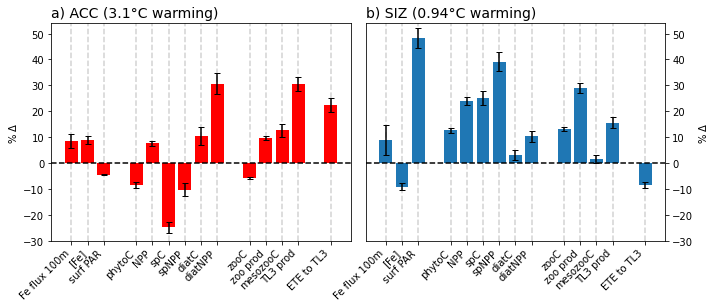

In [60]:
fig = plt.figure(figsize=(11,4))

labels = ['Fe flux 100m','[Fe]','surf PAR','phytoC','NPP','spC','spNPP','diatC','diatNPP','zooC','zoo prod','mesozooC','TL3 prod','ETE to TL3']
ind = np.arange(0,len(labels))

### ACC
vals = [frac_change_ACC_ds.phys_med_Fe.mean(dim='member_id')*100.,
       frac_change_ACC_ds.Fe_avg_100m.mean(dim='member_id')*100.,
       frac_change_ACC_ds.PAR_surf.mean(dim='member_id')*100., frac_change_ACC_ds.phytoC_zint.mean(dim='member_id')*100.,
       frac_change_ACC_ds.NPP_zint100m.mean(dim='member_id')*100., frac_change_ACC_ds.spC_zint100m.mean(dim='member_id')*100.,
       frac_change_ACC_ds.spNPP_zint100m.mean(dim='member_id')*100., frac_change_ACC_ds.diatC_zint100m.mean(dim='member_id')*100.,
       frac_change_ACC_ds.diatNPP_zint100m.mean(dim='member_id')*100., frac_change_ACC_ds.zooC_zint100m.mean(dim='member_id')*100.,
       frac_change_ACC_ds.zoo_prod_zint100m.mean(dim='member_id')*100., frac_change_ACC_ds.mesozooC.mean(dim='member_id')*100.,
       frac_change_ACC_ds.TL3_prod.mean(dim='member_id')*100.,frac_change_ACC_ds.ETE_to_TL3.mean(dim='member_id')*100.]

errors = [frac_change_ACC_ds_std.phys_med_Fe*100.,
       frac_change_ACC_ds_std.Fe_avg_100m*100.,
       frac_change_ACC_ds_std.PAR_surf*100., frac_change_ACC_ds_std.phytoC_zint*100.,
       frac_change_ACC_ds_std.NPP_zint100m*100., frac_change_ACC_ds_std.spC_zint100m*100.,
       frac_change_ACC_ds_std.spNPP_zint100m*100., frac_change_ACC_ds_std.diatC_zint100m*100.,
       frac_change_ACC_ds_std.diatNPP_zint100m*100., frac_change_ACC_ds_std.zooC_zint100m*100.,
       frac_change_ACC_ds_std.zoo_prod_zint100m*100., frac_change_ACC_ds_std.mesozooC*100.,
       frac_change_ACC_ds_std.TL3_prod*100.,frac_change_ACC_ds_std.ETE_to_TL3*100.]

ax = fig.add_subplot(1,2,1)
ax.bar(inds2, vals, color='red',yerr=errors,capsize=3)
ax.set_title('a) ACC (3.1°C warming)',fontsize=14,loc='left')
ax.set_ylabel('% ${\Delta}$')
ax.set_ylim(-30,54)
plt.xticks(inds2, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in ind:
    ax.axvline(inds2[i],linestyle='--',color='lightgray',zorder=0)

    
    
    
    
    
### SIZ
vals = [frac_change_SIZ_ds.phys_med_Fe.mean(dim='member_id')*100.,
       frac_change_SIZ_ds.Fe_avg_100m.mean(dim='member_id')*100.,
       frac_change_SIZ_ds.PAR_surf.mean(dim='member_id')*100., frac_change_SIZ_ds.phytoC_zint.mean(dim='member_id')*100.,
       frac_change_SIZ_ds.NPP_zint100m.mean(dim='member_id')*100., frac_change_SIZ_ds.spC_zint100m.mean(dim='member_id')*100.,
       frac_change_SIZ_ds.spNPP_zint100m.mean(dim='member_id')*100., frac_change_SIZ_ds.diatC_zint100m.mean(dim='member_id')*100.,
       frac_change_SIZ_ds.diatNPP_zint100m.mean(dim='member_id')*100., frac_change_SIZ_ds.zooC_zint100m.mean(dim='member_id')*100.,
       frac_change_SIZ_ds.zoo_prod_zint100m.mean(dim='member_id')*100., frac_change_SIZ_ds.mesozooC.mean(dim='member_id')*100.,
        frac_change_SIZ_ds.TL3_prod.mean(dim='member_id')*100.,frac_change_SIZ_ds.ETE_to_TL3.mean(dim='member_id')*100.]

errors = [frac_change_SIZ_ds_std.phys_med_Fe*100.,
       frac_change_SIZ_ds_std.Fe_avg_100m*100.,
       frac_change_SIZ_ds_std.PAR_surf*100., frac_change_SIZ_ds_std.phytoC_zint*100.,
       frac_change_SIZ_ds_std.NPP_zint100m*100., frac_change_SIZ_ds_std.spC_zint100m*100.,
       frac_change_SIZ_ds_std.spNPP_zint100m*100., frac_change_SIZ_ds_std.diatC_zint100m*100.,
       frac_change_SIZ_ds_std.diatNPP_zint100m*100., frac_change_SIZ_ds_std.zooC_zint100m*100.,
       frac_change_SIZ_ds_std.zoo_prod_zint100m*100., frac_change_SIZ_ds_std.mesozooC*100.,
       frac_change_SIZ_ds_std.TL3_prod*100.,frac_change_SIZ_ds_std.ETE_to_TL3*100.]

ax = fig.add_subplot(1,2,2)
ax.bar(inds2, vals,yerr=errors,capsize=3)
ax.set_title('b) SIZ (0.94°C warming)',fontsize=14,loc='left')
ax.set_ylabel('% ${\Delta}$')
ax.set_ylim(-30,54)
plt.xticks(inds2, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
for i in ind:
    ax.axvline(inds2[i],linestyle='--',color='lightgray',zorder=0)
plt.subplots_adjust(wspace=0.05)

fig.savefig('/glade/work/kristenk/figs/fig2_barplot.png', bbox_inches='tight', dpi=300, format='png');

In [58]:
frac_change_SIZ_ds.ETE_to_TL3*100.

<xarray.DataArray 'ETE_to_TL3' ()>
array(-8.43997041)
Attributes:
    long_name:     trophic level 3 production
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [61]:
cluster.close()